In [1]:
import fastai.data.all as fai_data
import fastai.vision.all as fai_vision
import torch
import torchvision
from matplotlib import pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
path = fai_data.untar_data(fai_data.URLs.MNIST)
path

Path('/home/daynil/.fastai/data/mnist_png')

In [4]:
dls = fai_vision.DataBlock(
    blocks=(fai_vision.ImageBlock, fai_vision.MultiCategoryBlock),
    get_items=fai_vision.get_image_files,
    splitter=fai_vision.GrandparentSplitter('training', 'testing'),
    get_y=fai_vision.parent_label
).dataloaders(path)

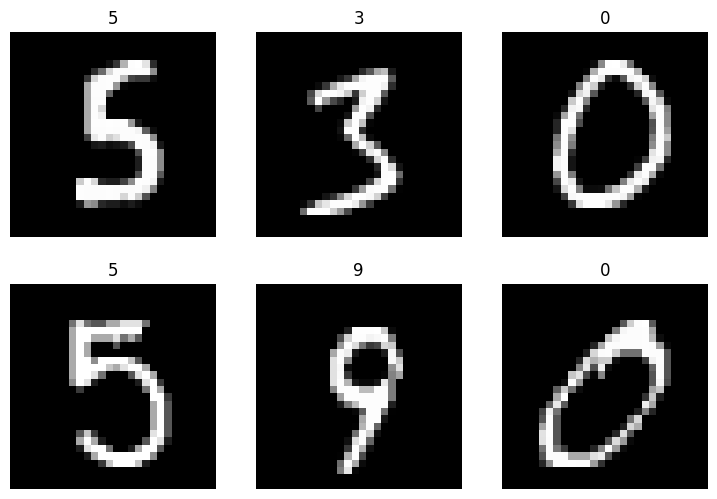

In [5]:
dls.show_batch(max_n=6)

In [6]:
images, labels = dls.train.one_batch()
# We have a batch of 64 images, with an RGB stack (3) of 28x28 pixels
images.shape

torch.Size([64, 3, 28, 28])

TensorMultiCategory(5, device='cuda:0')


<Axes: >

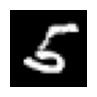

In [7]:
one_image = images[0]
print(labels[0].argmax())
one_image.show()

For the purposes of our pure python learner version, we want to compress the RGB image to grayscale, then combine all of the pixel rows into 1 row. This way, we can assign a weight to each pixel.

In [141]:
gray_image = torchvision.transforms.functional.rgb_to_grayscale(one_image)
gray_image_squeezed = gray_image.squeeze()
gray_image_squeezed_flattened = gray_image_squeezed.flatten()
one_image.shape, gray_image.shape, gray_image_squeezed.shape, gray_image_squeezed_flattened.shape

(torch.Size([3, 28, 28]),
 torch.Size([1, 28, 28]),
 torch.Size([28, 28]),
 torch.Size([784]))

In [142]:
# Pixels per dimension
px_per_dim = 28
images_tfmd = (
    torchvision.transforms.functional
        .rgb_to_grayscale(images).squeeze().view(64, px_per_dim**2)
)
images_tfmd.shape

torch.Size([64, 784])

In [6]:
# Pixels per dimension
px_per_dim = 28
torch.random.manual_seed(42)

To create a simple 1-layer neural network, we need to initialize the parameters in a particular way.

First, we need a weight for each pixel in the image, so 28*28 (784) weights, as well as a bias. This produces the parameters for a single neuron.

One neuron won't be enough to do anything useful, so we create this set of parameters for the amount of neurons we want, in this case, 100. Effectively, we get a set of 784 weights and 1 bias for each of the 100 neurons.

We represent this with tensors by creating a weights tensor and a bias tensor. The weights tensor is (pixels, hidden_neurons), and the bias is just hidden_neurons.

We have a second set of parameters for our output layer. This layer's input is the size of the prior layer's output (in this case, number of neurons), and the output is the number of predictions we want, which is 1 for each digit in the mnist dataset (10 aka digits 0-9).

Note that **each layer's input is the size of the prior layer's output**. So for the first layer, the input is the size of the image in pixels (784), and for the second layer, the input is the size of the prior layer's output, the number of neurons (100 - **we get a single number of output - an activation - for each neuron**).

An important concept to emphasize here is that, no matter what the size of each item that a neuron gets as input (784 pixels, or 100 activations - 1 from each of the neurons in the prior layer), **it will always produce a single number as its activation**. $f(y=wx+b)$ is always 1 number. It represents the strength of the connection of that neuron with the subsequent layer, and is the basis by which neural networks learn. Layers of neurons build on each other.

In [7]:
hidden_neurons = 100
# There are a total of 10 number classes (digits 0-9)
mnist_classes = 10

weights_layer_1 = torch.randn((px_per_dim**2, hidden_neurons), requires_grad=True, device=device)
bias_layer_1 = torch.randn(hidden_neurons, requires_grad=True, device=device)

weights_layer_2 = torch.randn((hidden_neurons, mnist_classes), requires_grad=True, device=device)
bias_layer_2 = torch.randn(mnist_classes, requires_grad=True, device=device)

Breaking down each of the model's forward pass, we have:

First linear layer:
Matrix multiply a batch of images by its weights and add the biases:
$$y = wx + b$$

This gives us a single output, y, for each neuron, so we have **100 total outputs per image**.

It's hard to associate this linear equation properly *per image* because matrix multiplication involves two "layers" of data - a `batch` of `batch_size` images as well as a set of weights of length `px` (pixels per image). If we apply the equation above to a single image, we get:

$$y = w_{px}x_{px} + b$$

This means we're matrix multiplying each individual pixel in the image by a weight for that image, then adding a bias. So here, y is the result for a single image, for a single neuron.

However, in practice, we never use a single data item in our matrix multiplication because the GPU needs to have enough data to process for it to be efficient. Likewise, we also usually have more than one neuron in a given layer.

In [8]:
res = images_tfmd@weights_layer_1 + bias_layer_1
res.shape

NameError: name 'images_tfmd' is not defined

In [ ]:
res[0]

TensorImage([[ 5.8395e-01,  7.7099e-01,  3.2095e-01,  ...,  1.6309e+01,
               1.5097e+01,  8.4860e+00],
             [-2.3377e+00, -5.4933e+00,  2.7442e+00,  ...,  1.1085e+01,
              -1.6795e+00, -7.7791e+00],
             [ 8.8088e+00, -4.0023e-02, -7.4369e+00,  ...,  1.4133e+01,
               1.4072e+00, -5.3275e+00],
             ...,
             [ 2.4089e+01, -1.4402e-02,  1.4289e+01,  ...,  4.3825e+00,
               2.3052e+00, -5.7478e+00],
             [ 1.2136e+01, -6.9187e-01,  1.0098e+01,  ...,  1.6278e+01,
               1.4465e+00,  4.1869e-01],
             [ 9.3971e+00, -2.5722e+00,  4.3713e+00,  ...,  2.8283e-01,
               5.3905e+00,  3.2354e+00]], device='cuda:0',
            grad_fn=<AliasBackward0>)

So here, we're taking a batch of 64 images of 784 pixels each, our first matrix, and performing matrix multiplication by 784 weights (one for each pixel) for 100 neurons. The resulting matrix is, for each of the 64 images in the batch, we get a single activation for each of the 100 neurons. We then do a final matrix addition operation, adding the bias for each neuron the the result of the matrix multiplication.

It's a very simple linear equation, but the fact that this vast number of computations can be encompassed by a single operation took some time for me to fully digest and appreciate.

All of this comes together very elegently on a GPU, where the process can be extensively parallelized across many threads and cores, resulting in an extremely fast and efficient operation.

Ultimately, we're performing the $y = w_{px}x_{px} + b$ operation in parallel for batches of multiple items and for multiple neurons.

The next step is to use an activation function such as a ReLU to apply a nonlinearity to each of our neurons. All this does is turns negative values to 0 and leaves positive values as they are.

In [200]:
res = torch.nn.ReLU()(res)

Then, we can repeat the same linear operation as before, but now on the set of 64 batches of 100 linear activations from the previous layer matrix multiplied by a new set of 100 weights for each activation for each of our 10 final neurons.

In [207]:
res = res@weights_layer_2 + bias_layer_2
res.shape

torch.Size([64, 10])

This produces a set of 64 batches of logits, one for each image. The logits are a vector of 10 numbers representing the raw predictions of our model for each of the 10 digits in the mnist dataset.

In [213]:
res[1]

TensorImage([-42.5143, 141.6074, -76.3715, -12.9963, -72.4300, 121.3955,
             242.9164, 108.5102,  31.6789, -50.5750], device='cuda:0',
            grad_fn=<AliasBackward0>)

Finally, we can normalize our 10 logits using the softmax function, which produces values between 0 and 1, representing the model's final predicted probability that the given image is one each of the 10 digits in our dataset.

In [214]:
res = torch.nn.Softmax(dim=1)(res)
res[1]

TensorImage([0.0000e+00, 9.8091e-45, 0.0000e+00, 0.0000e+00, 0.0000e+00,
             0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
            device='cuda:0', grad_fn=<AliasBackward0>)

In [215]:
res[1].argmax()

TensorImage(6, device='cuda:0')

In this case, the model is close to 100% certain that the image is of the number 6.

TODO:
Add a simplified visualization of the above matrix multiplication and neural network using batches of 2 images that are 2x2 pixels with 3 neurons.

Putting it all together, we can create a function which represents our forward pass through our model.

In [8]:
def simple_net(image_batch):
    res = image_batch@weights_layer_1 + bias_layer_1
    res = torch.nn.ReLU()(res)
    res = res@weights_layer_2 + bias_layer_2
    # This needs to go later (cross entropy loss expects unnormalized logits)
    # res = torch.nn.Softmax(dim=1)(res)
    return res

Now, we need to implement the actual training and validation logic, which will automate the process of updating the weights. First, we need to a loss function to determine how good or bad our predictions are.

For multi-class classification, we use cross entropy. This is basically a fancy way of saying the loss increases based on distance from the correct answer. So if the digit was actually a 4, and our predicted probability for 4 was 0.01%, our loss would be very high, if our predicted probability for 4 was 55.2%, our loss would be lower, and if our predicted probability was 99.5%, our loss would be very low.

[StatQuest: Neural Networks Part 6: Cross Entropy](https://www.youtube.com/watch?app=desktop&v=6ArSys5qHAU)

In [7]:
# Common code for pure python and pytorch
def to_torch_tensor(xb: torch.Tensor, yb):
    return torch.tensor(xb, device=device), torch.tensor(yb, device=device)

def to_bw_flattened(xb):
    return (torchvision.transforms.functional
                    .rgb_to_grayscale(xb).squeeze().view(
                        xb.shape[0], px_per_dim**2)
                )

def accuracy(preds, yb):
    accuracy_tns = (preds.argmax(dim=1) == yb.argmax(dim=1)).float()
    return (accuracy_tns.sum() / len(accuracy_tns)).item()

loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
epochs = 50
lr = 0.001
train_loss = []
train_acc = []
valid_acc = []
valid_loss = []

def optimize(loss):
    params = [weights_layer_1, bias_layer_1, weights_layer_2, bias_layer_2]

    loss.backward()

    for param in params:
        param.data -= param.grad.data * lr
    
    for param in params:
        param.grad.zero_()


def train_step(xb, yb):
    preds = simple_net(xb)
    loss = loss_fn(preds, yb)
    acc = accuracy(preds, yb)
    optimize(loss)
    return loss, acc

def valid_step(xb, yb):
    with torch.inference_mode():
        preds = simple_net(xb)
        loss = loss_fn(preds, yb)
        acc = accuracy(preds, yb)
        return loss, acc

for epoch in range(epochs):
    print(f"Epoch {epoch}...")

    tot_loss, tot_acc = 0, 0
    for batch in dls.train:
        xb, yb = batch
        xb = to_bw_flattened(xb)
        xb, yb = to_torch_tensor(xb, yb)
        loss, acc = train_step(xb, yb)
        tot_loss += loss
        tot_acc += acc
    
    batches = len(dls.train)
    avg_loss = tot_loss / batches
    avg_acc = tot_acc / batches
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)
    print(f'Train loss: {avg_loss} - Train acc: {avg_acc}')
    
    tot_loss, tot_acc = 0, 0
    for batch in dls.valid:
        xb, yb = batch
        xb = to_bw_flattened(xb)
        xb, yb = to_torch_tensor(xb, yb)
        loss, acc = valid_step(xb, yb)
        tot_loss += loss
        tot_acc += acc

    batches = len(dls.valid)
    avg_loss = tot_loss / batches
    avg_acc = tot_acc / batches
    valid_loss.append(avg_loss)
    valid_acc.append(avg_acc)
    print(f'Valid loss: {avg_loss} - Valid acc: {avg_acc}')

Epoch 0...


/tmp/ipykernel_23588/3251691938.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(xb, device=device), torch.tensor(yb, device=device)


Train loss: 35.14687728881836 - Train acc: 0.25136739594450375
Valid loss: 19.50116729736328 - Valid acc: 0.40893710191082805
Epoch 1...
Train loss: 15.131706237792969 - Train acc: 0.48479188900747067
Valid loss: 11.479949951171875 - Valid acc: 0.5625
Epoch 2...
Train loss: 10.204293251037598 - Train acc: 0.5935332177161152
Valid loss: 8.56705093383789 - Valid acc: 0.6432125796178344
Epoch 3...
Train loss: 8.060382843017578 - Train acc: 0.6518309765208111
Valid loss: 7.091747760772705 - Valid acc: 0.6878980891719745
Epoch 4...
Train loss: 6.833016395568848 - Train acc: 0.6881503468516542
Valid loss: 6.159182548522949 - Valid acc: 0.7158638535031847
Epoch 5...
Train loss: 6.009582042694092 - Train acc: 0.7129469050160085
Valid loss: 5.502294540405273 - Valid acc: 0.7344745222929936
Epoch 6...
Train loss: 5.413011074066162 - Train acc: 0.7310065368196371
Valid loss: 5.020163059234619 - Valid acc: 0.7498009554140127
Epoch 7...
Train loss: 4.958773136138916 - Train acc: 0.7459978655282817


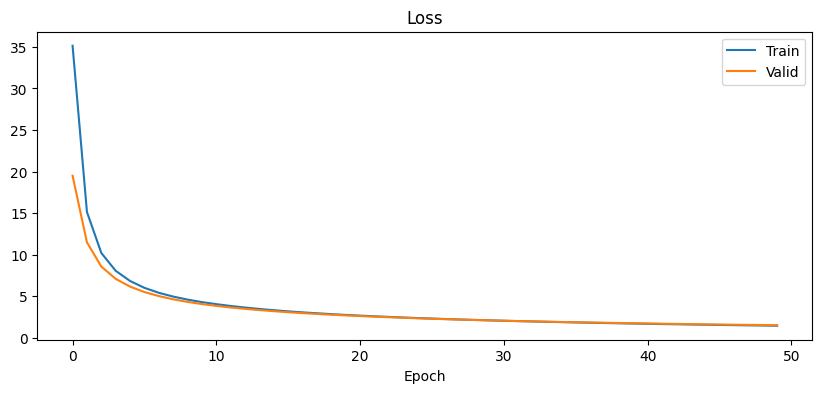

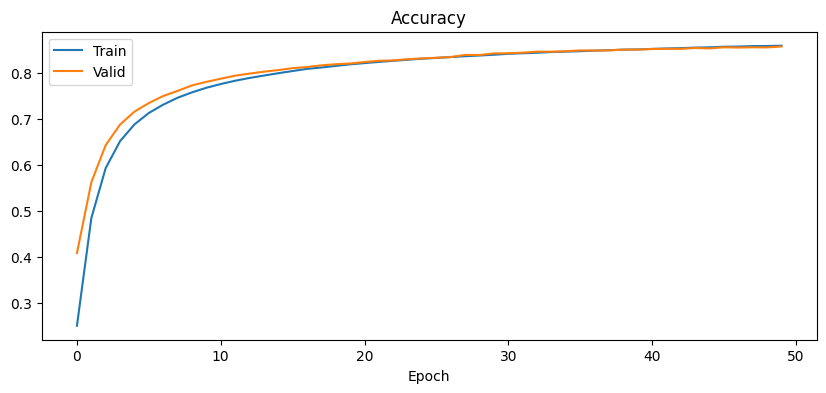

In [17]:
x = range(0, len(train_loss))
# train_loss = [item.item() for item in train_loss]
valid_loss = [item.item() for item in valid_loss]
plt.figure(figsize=(10, 4))
plt.title('Loss')
plt.xlabel('Epoch')
plt.plot(x, train_loss, label="Train")
plt.plot(x, valid_loss, label="Valid")
plt.legend()
plt.show()

x = range(0, len(train_acc))
plt.figure(figsize=(10, 4))
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.plot(x, train_acc, label="Train")
plt.plot(x, valid_acc, label="Valid")
plt.legend()
plt.show()

Prediction: 4, Probability: 100.000%
Actual: 4


<Axes: >

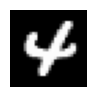

In [18]:
# If I want to test a different batch than provided by one_batch()
# How else can I do this without iterating? Indexing and using next() doesn't work
# How does fastai allow a loop then?
# idx = 0
# for batch in dls.valid:
#     if idx == 43:
#         images, labels = batch
#         break
#     idx += 1


images, labels = dls.valid.one_batch()
image_tfmd = to_bw_flattened(images)[0]

logits = simple_net(image_tfmd)
preds = torch.nn.Softmax(dim=0)(logits)
print(f"Prediction: {preds.argmax().item()}, Probability: {preds[preds.argmax().item()].item()*100:0.03f}%")
print(f"Actual: {labels[0].argmax().item()}")
images[0].show()

Here's the core code all in one block, compressed and with logging omitted for clarity.

In [ ]:
hidden_neurons = 100
mnist_classes = 10

w1 = torch.randn((px_per_dim**2, hidden_neurons), requires_grad=True, device=device)
b1 = torch.randn(hidden_neurons, requires_grad=True, device=device)

w2 = torch.randn((hidden_neurons, mnist_classes), requires_grad=True, device=device)
b2 = torch.randn(mnist_classes, requires_grad=True, device=device)

def simple_net(image_batch):
    res = image_batch@w1 + b1
    res = torch.nn.ReLU()(res)
    res = res@w2 + b2
    return res

def optimize():
    params = [w1, b1, w2, b2]
    for param in params:
        param.data -= param.grad.data * lr
    
    for param in params:
        param.grad.zero_()

def train_step(xb, yb):
    preds = simple_net(xb)
    loss = loss_fn(preds, yb)
    acc = accuracy(preds, yb)

    loss.backward()
    optimize(loss)
    return loss, acc

def valid_step(xb, yb):
    with torch.inference_mode():
        preds = simple_net(xb)
        loss = loss_fn(preds, yb)
        acc = accuracy(preds, yb)
        return loss, acc

epochs = 50
lr = 0.001

for epoch in range(epochs):
    for batch in dls.train:
        xb, yb = batch

        # These two are just for compatability between fastai batches and our method
        # Can ignore, conceptually
        xb = to_bw_flattened(xb)
        xb, yb = to_torch_tensor(xb, yb)
        
        loss, acc = train_step(xb, yb)
    
    for batch in dls.valid:
        xb, yb = batch
        xb = to_bw_flattened(xb)
        xb, yb = to_torch_tensor(xb, yb)
        loss, acc = valid_step(xb, yb)

We've just trained a model to identify written digits from an image with around 80% accuracy in mostly pure Python! We're still operating with tensors in order to get automatic gradient calculation, but other than that, this is a simple representation of the core, explicit code that goes into training an image model.

## Deep Learning - Digested

To solidify the foundational concepts of deep learning, we can go through each step in the process of data prep, a single loop through a training batch, and subsequent use of a model to make a prediction. We should concretely visual all of these as we go through them.

Deep learning, and machine learning in general, begins with the data. Everything in life can be represented as numbers, so we're not limited to just data that is already numerical. Images, sound, and even text data (via embeddings) can be represented as numbers.

The input of a single data item to a neural network is a vector of numbers. For tabular data, this is all the columns of a row of data (with non-numerical data either encoded or embedded). For sound and images, this is all of the samples or pixels. For text data, this is the embeddings. Regardless, it is always just a vector of numbers. In effect, conceptually, **as far as the model is concerned, there is no difference between a vector representing actual numerical data, pixels in an image, samples in an audio file, or embeddings in a text file**.

It is most useful, conceptually, to think of how data is passed through the model using a single data item. The vector of numbers for the item is passed through to each neuron in the first layer. Each neuron in the first layer has an input size of the length of the vector of numbers. **Each neuron, regardless of the input size, always outputs a single number** - its activation. This is the strength of the signal that is passed to the next layer from that particular neuron. Each neuron in the next layer takes each activation from the prior layer, and again outputs a single activation of its own. 

The output layer always has the number of neurons we need to produce the type of data we need for our task. For regression, that is a single neuron, since we are just predicting a number. For classification, the number of neurons is equal to the number of classes for which we need to be able to make a prediction. A dog vs. cat classifier is 2 neurons, while a cat breed identifier has as many neurons as there are breeds we want to predict. The output of each neuron in the output layer reprsents the model's predicted probability for one of the classes in the classification task.

Layering on conceptually, we never actually pass a single data item through a model at a time, because that would be very inefficient. Efficient use of a GPU requires that you pass enough data in to make the process of transferring data to it worthwile. We do this using batches of data. So instead of a single vector of numbers, a single data item, we have a batch of, for example, 64 vectors of numbers. The calculations in a model for a batch of data occurs in parallel on the GPU using matrix multiplication. However, the ultimate result is more easily visualized as an operation in series.

To begin, we initialize the parameters for all the neurons in all the layers in our model, the weights and the biases. Each neuron in the first layer has as many weights as the length of the input vector for a single item, and each neuron in every subsequent layer has as many weights as the number of neurons in the prior layer. Every neuron in every layer has a single bias, which is used to avoid loss of information when an input value is 0.

As an example, we use the MNIST dataset, handwritten digits in a 28x28 black and white image. We flatten this to a vector of 784 numbers. If we select a batch size of 64, our input matrix is 64 vectors of 784 pixels (64, 784). If we select 100 neurons in our first layer, we have a matrix of weights that is (784, 100), a weight for each pixel, for each of the 100 neurons. We also have a vector of 100 biases, one for each of the 100 neurons. 

The parameters are initialized as tensors of random numbers with gradient calculation enabled. **Only** the parameter tensors have gradient calculation enabled - input tensors do not.

Passing a single batch of 64 images through the first layer, matrix multiplication of the input matrix (64, 784) times the weights matrix (784, 100) occurs first. This produces a matrix of (64, 100) - for each of the 64 images in the batch, we have 100 activations - a single one for each neuron. Next, we do matrix addition of the matrix multiplication result, (64, 100), plus the vector of 100 biases. The vector of 100 biases is broadcast into a matrix of (64, 100), so we have a bias for each neuron and each item in the batch. This results in the same (64, 100) matrix. We apply a nonlinear activation function to each of the results here, which is the final activation for that neuron. We need a nonlinearity between linear layers because stacking linear layers just produces more linear functions, so no useful combinations can be created unless we have a nonlinearity between each.

The resulting activation of each neuron is basically represented as $f(y = w@x + b)$, where f is the activation function.

For each subsequent layer of neurons, the same process occurs. For the second layer, in this  case the output layer, we have a parameters matrix of (100, 10), a weight for each of the activations of the prior layer neurons, for each of the 10 neurons in this layer. We have 10 in this output layer because there are 10 digits in the MNIST dataset to clasify (0-9). After the matrix operations on this layer, we have a matrix of (64, 10) numbers, a vector of 10 logits for each image in the batch. These are the raw, unnormalized predictions of the model. 

The highest value of each logits vector is effectively the model's prediction for the current data item. Typically, we'd need to do some normalization of the data in the output layer to get a final result. In the case of classification, we use the Softmax function (S shaped curve) which compresses all the logits into a range of numbers from 0-1 which collectively add up to 1. This represents the predicted probabilities of the model for each class. If we were doing regression, we may scale the final prediction into the appropriate range for our data's domain.

To train the model, we loop through each batch of items in the dataloader for a number of epochs, each of which encompass a full pass through all the data. For each batch in an epoch, we pass the batch of input data through the model to produce the predictions. Then, we pass the predictions and the labels for the batch into the loss function to get a loss that tells us how well the model is doing. For classification, the loss is not just whether the model is correct, because this would not be continously differentiable (we would osscilate between gradients of 0 and infinity). Instead, we grade the prediction based on both whether it is right and how conident it is (confident and wrong is highest loss, confident and correct is lowest). 

Next, we perform a backwards pass through the model to calculate the gradients, which is basically calculating the partial derivative of each parameter with respect to the loss function. The partial derivative of a loss function for a parameter tells us the instantaneous rate of change of the loss function for that parameter, if all other parameters are held constant. Essentially, this lets us know how the loss would change if we adjusted the parameter slightly in one direction or another.

Based on the gradients calculated, we use an optimizer to step each parameter in the direction *opposite* the gradient (think of the U quadratic loss function of $y = x^2$) times the learning rate. The gradient tells us both the direction to step each parameter, and the relative magnitude we should step by. The learning rate is an important balancing act of avoiding extremely slow training with a learning rate too low, as well as avoiding bouncing around and possibly diverging with a learning rate too high. This is the full process to train a single batch. We repeat this for every batch in the dataloader, and the model improves slightly each time. 

Validating a batch is the same process, but without the backwards pass and subsequent optimization. After we've done a training pass on every batch in the dataloader, we then do a validation pass, which tells us how well our model is *actually* doing because it uses data that the model was not trained on (training set vs. validation set). 

We repeat these training and validation passes for each epoch. The amount of epochs we use depends on a number of factors, but ultimately, we can train until the model either stops improving or starts getting worse.

Making a prediction on a new image is simply passing the vector of numbers representing the image through the model with the trained parameters to get the model's predicted probabilities (or the predicted number, in the case of regression).

## PyTorch Version

Now that we've had a look at the Python version, let's update our code to fully leverage the PyTorch framework.

There are a few main components we can simplify with PyTorch here - parameter initialization, model definition and the optimizer.

In [9]:
hidden_neurons = 100
mnist_classes = 10

epochs = 50
lr = 0.001

model = torch.nn.Sequential(
    torch.nn.Linear(px_per_dim**2, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, mnist_classes)
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def train_step(xb, yb):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    acc = accuracy(preds, yb)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss, acc

def valid_step(xb, yb):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    acc = accuracy(preds, yb)
    return loss, acc

for epoch in range(epochs):
    model.train()
    for batch in dls.train:
        xb, yb = batch
        xb = to_bw_flattened(xb)
        xb, yb = to_torch_tensor(xb, yb)
        loss, acc = train_step(xb, yb)
    
    tot_loss, tot_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch in dls.valid:
            xb, yb = batch
            xb = to_bw_flattened(xb)
            xb, yb = to_torch_tensor(xb, yb)
            loss, acc = valid_step(xb, yb)
            tot_loss += loss
            tot_acc += acc
    
    valid_batches = len(dls.valid)
    print(f"Avg loss: {tot_loss / valid_batches}, Avg acc: {tot_acc / valid_batches}")

/tmp/ipykernel_10474/3251691938.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(xb, device=device), torch.tensor(yb, device=device)


Avg loss: 2.1190261840820312, Avg acc: 0.4876592356687898
Avg loss: 1.8594677448272705, Avg acc: 0.6716759554140127
Avg loss: 1.5546401739120483, Avg acc: 0.734375
Avg loss: 1.266465663909912, Avg acc: 0.7753781847133758
Avg loss: 1.0422288179397583, Avg acc: 0.8055334394904459
Avg loss: 0.8828763961791992, Avg acc: 0.8252388535031847
Avg loss: 0.7713491320610046, Avg acc: 0.8363853503184714
Avg loss: 0.6914654970169067, Avg acc: 0.8484275477707006
Avg loss: 0.6321320533752441, Avg acc: 0.8558917197452229
Avg loss: 0.5866104960441589, Avg acc: 0.8621616242038217
Avg loss: 0.5503419041633606, Avg acc: 0.8682324840764332
Avg loss: 0.5211775302886963, Avg acc: 0.8732085987261147
Avg loss: 0.4969557225704193, Avg acc: 0.8778861464968153
Avg loss: 0.4767436683177948, Avg acc: 0.8811703821656051
Avg loss: 0.45953068137168884, Avg acc: 0.8842555732484076
Avg loss: 0.4445933401584625, Avg acc: 0.8857484076433121
Avg loss: 0.4315435290336609, Avg acc: 0.8885350318471338
Avg loss: 0.420177012681

## Fastai Version

In [9]:
hidden_neurons = 100
mnist_classes = 10

epochs = 50
lr = 0.001

class GrayFlatLayer(torch.nn.Module):
    def __init__(self, lambd):
        super().__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

model = torch.nn.Sequential(
    GrayFlatLayer(torchvision.transforms.Lambda(to_bw_flattened)),
    torch.nn.Linear(px_per_dim**2, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, mnist_classes)
).to(device)

# Note this is using my common accuracy function (not the fastai accuracy)
# There's some compatability issues using their acc function (probably due to the way
# I'm manipulating the image).
# **NOTE** Issue seems to be that I used MultiCategoryBlock instead of CategoryBlock in
# the dataloaders code
# TODO: make a clean version using to guide dataset creation
# https://github.com/fastai/fastai/blob/master/nbs/examples/migrating_pytorch.py
learner = fai_vision.Learner(
    dls, model, lr=lr, loss_func=loss_fn, opt_func=fai_vision.SGD, metrics=accuracy
)

learner.fit(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.129946,2.114764,0.593900,00:06
1,1.881100,1.853661,0.714400,00:06
2,1.572883,1.541816,0.761300,00:06
3,1.283322,1.249866,0.792200,00:06
4,1.046620,1.027308,0.814100,00:06
5,0.903751,0.872338,0.830000,00:06
6,0.802927,0.764822,0.843300,00:06
7,0.706461,0.687306,0.852000,00:06
8,0.653654,0.629597,0.860000,00:06
9,0.618564,0.585336,0.865100,00:06


In [12]:
epochs = 5

learner = fai_vision.vision_learner(
    dls, fai_vision.resnet18, metrics=accuracy
)

learner.fine_tune(epochs)

epoch,train_loss,valid_loss,accuracy,time
0,0.115750,0.080717,0.858600,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.022116,0.012227,0.980000,00:20
1,0.011561,0.007477,0.987300,00:51
2,0.008046,0.005278,0.990800,00:18
3,0.003458,0.005133,0.992300,00:18
4,0.002332,0.004719,0.993000,00:18


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1a5fd45f80>
Traceback (most recent call last):
  File "/home/daynil/mambaforge-pypy3/envs/ai-base/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/daynil/mambaforge-pypy3/envs/ai-base/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/daynil/mambaforge-pypy3/envs/ai-base/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daynil/mambaforge-pypy3/envs/ai-base/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daynil/mambaforge-pypy3/envs/ai-base/lib/python3.11/multiprocessing/connection.py", line 947, in wait
    ready = s